## Инструкция по сдаче ДЗ.



0. Просмотр лекции обязателен. Не потому что без этого невозможно выполнить домашнее задание, а потому что с этим выполнение домашнего задания станет комфортным, приятным и быстрым. Вы потратите намного меньше времени для изучения материала и понимания того, что от Вас хотят, нежели сразу приступите к выполнению домашнего задания без просмотра лекции.

1. Скопируйте к себе колаб-ноутбук.

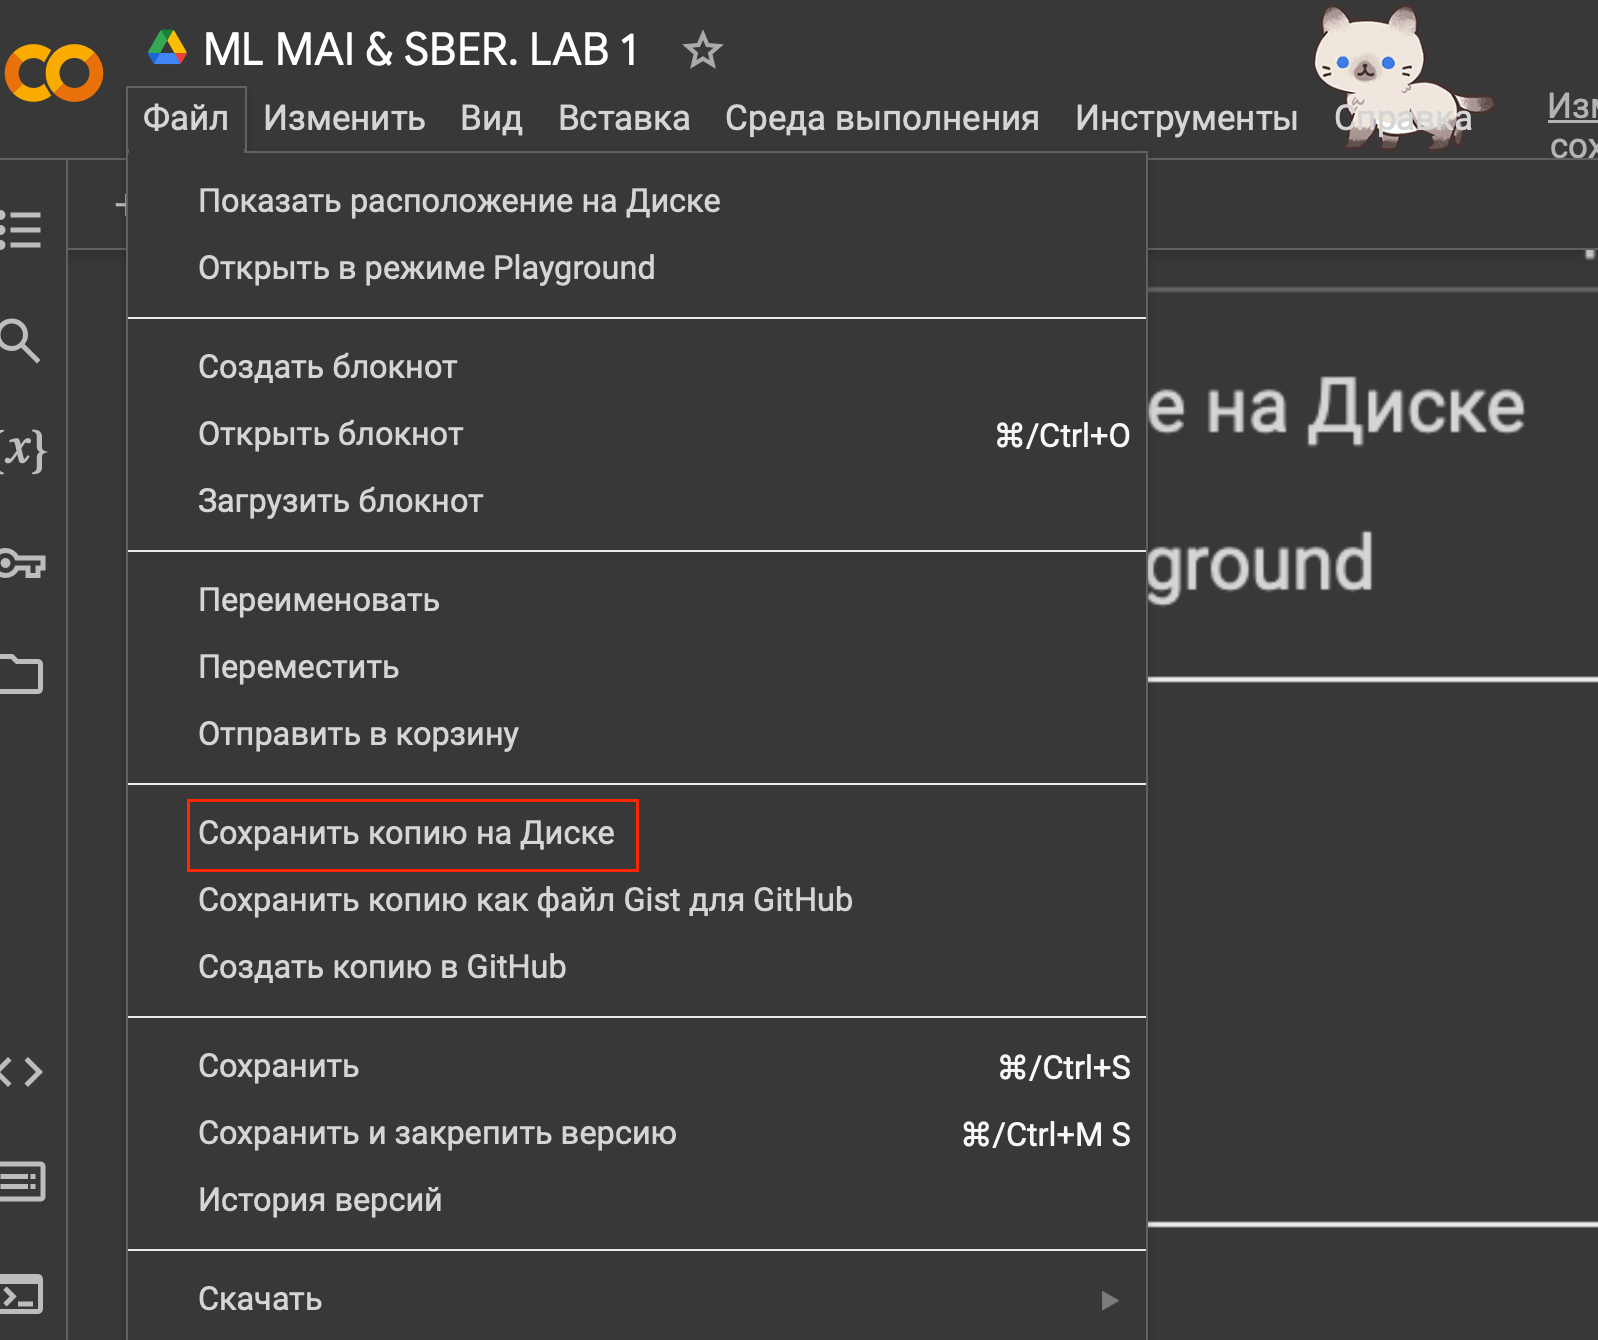

2. у Вас откроется файл в новой вкладке с названием "Копия...". После описания задания вы пишите решение этого задания.

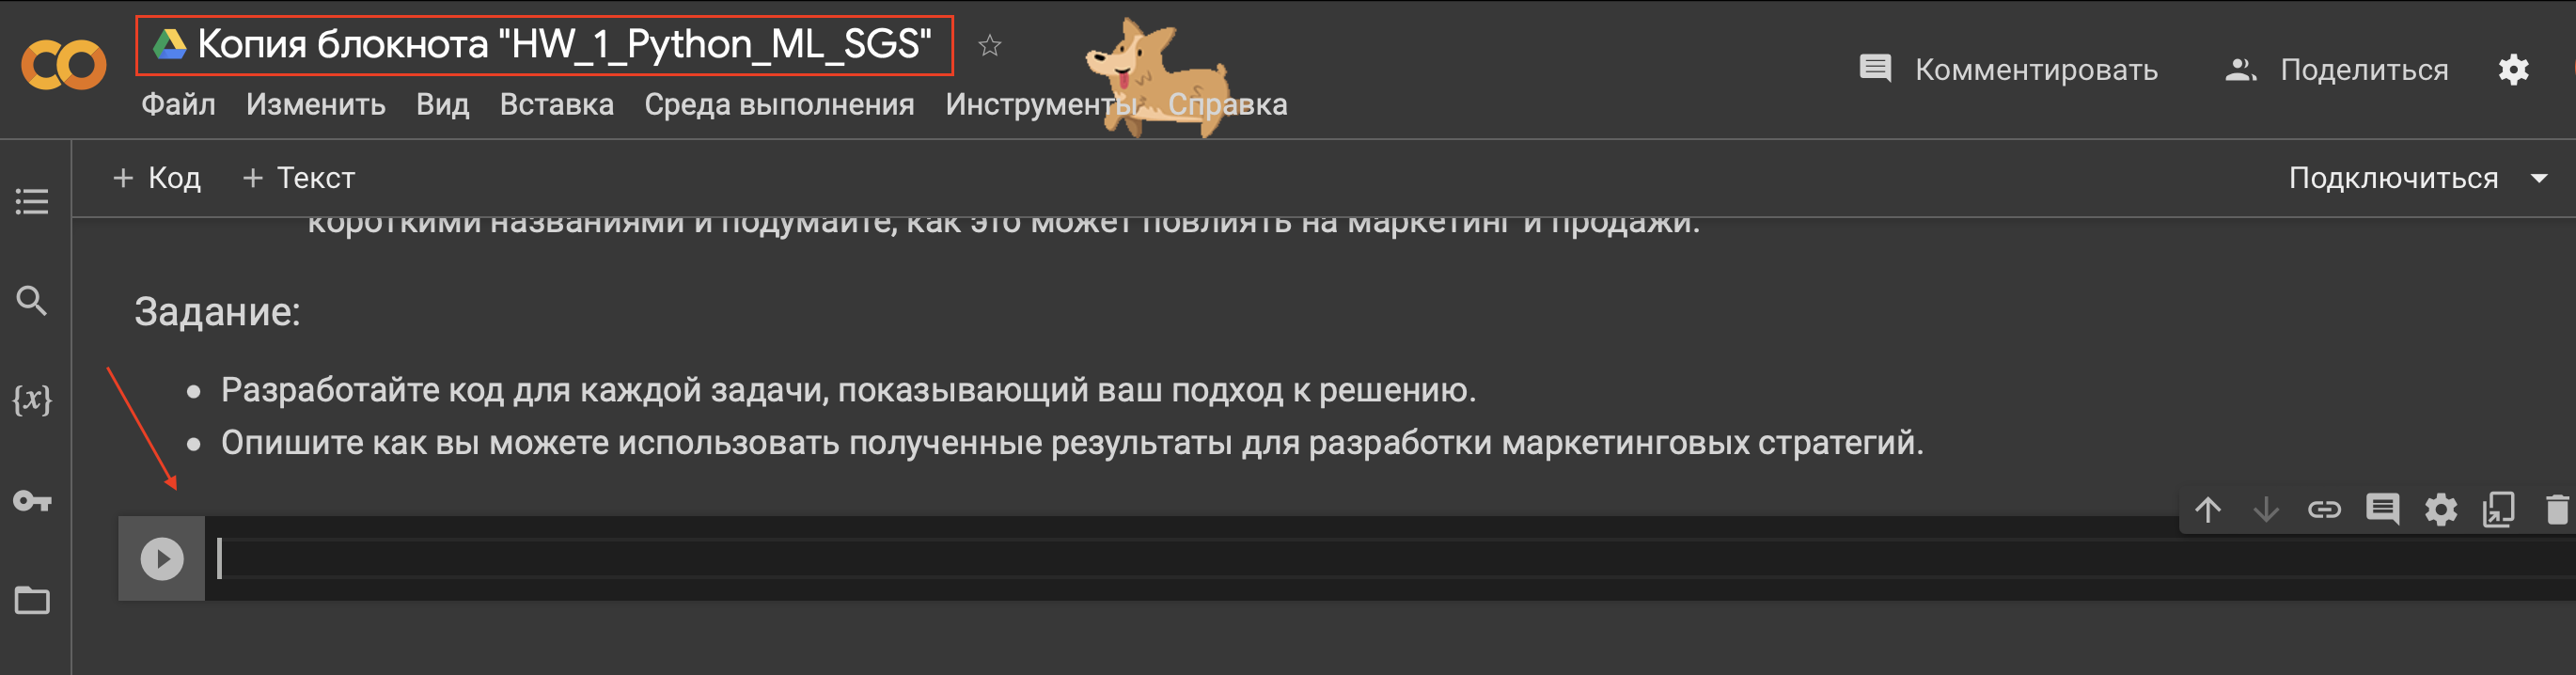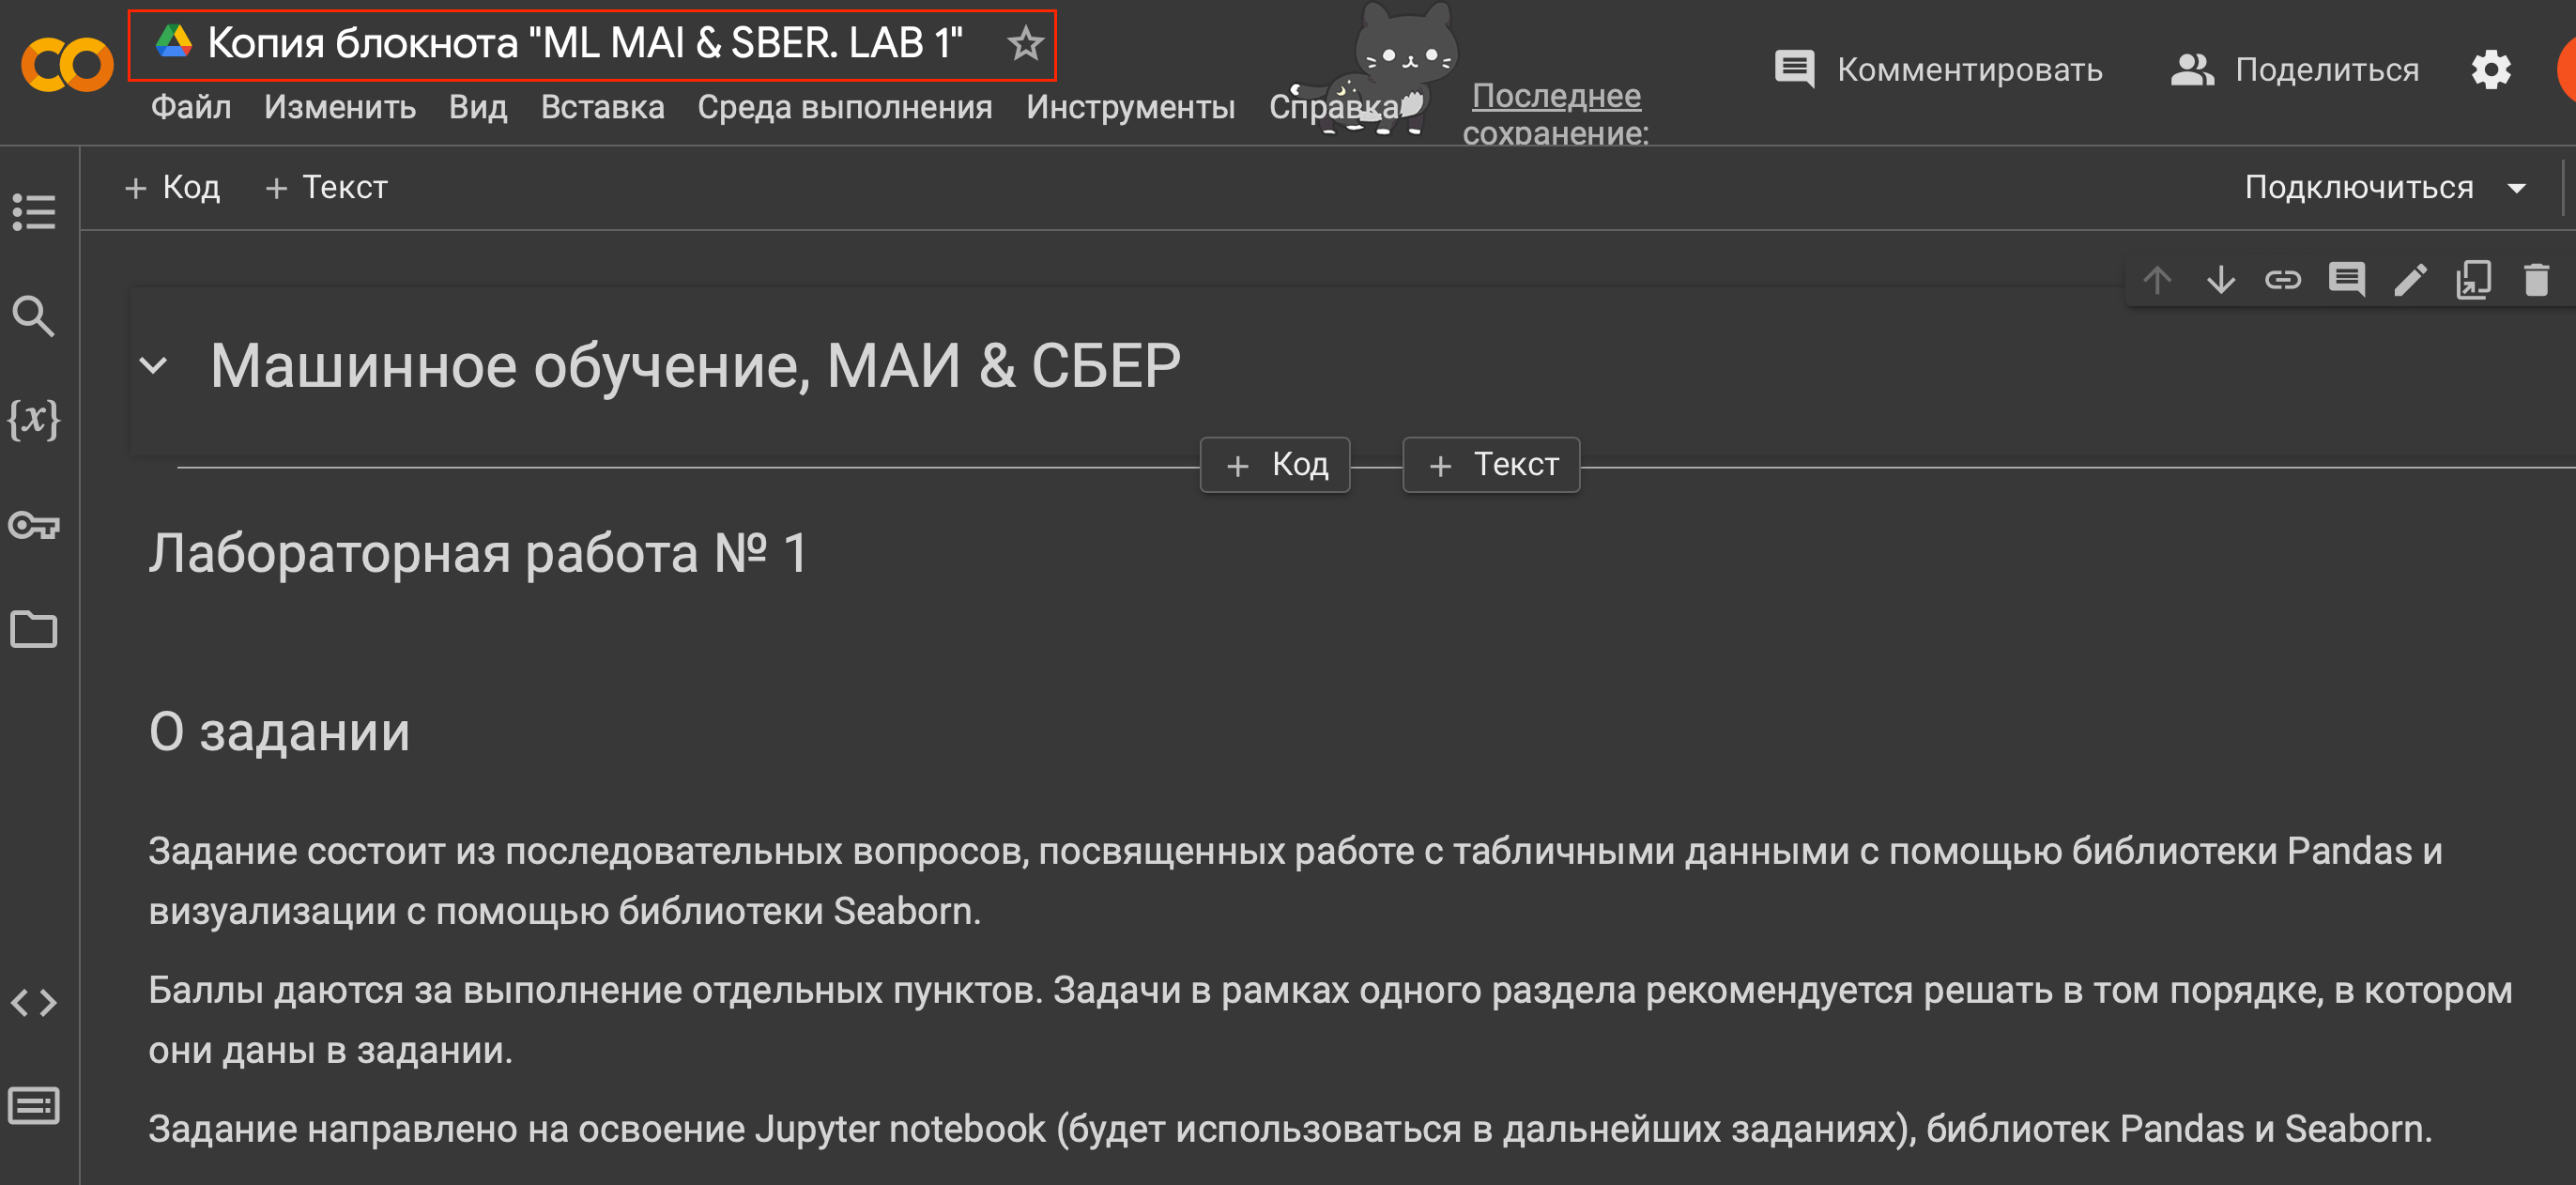

3. После выполнения домашнего задания нажмите кнопку "поделиться" и перейдите в режим доступно всем по ссылке

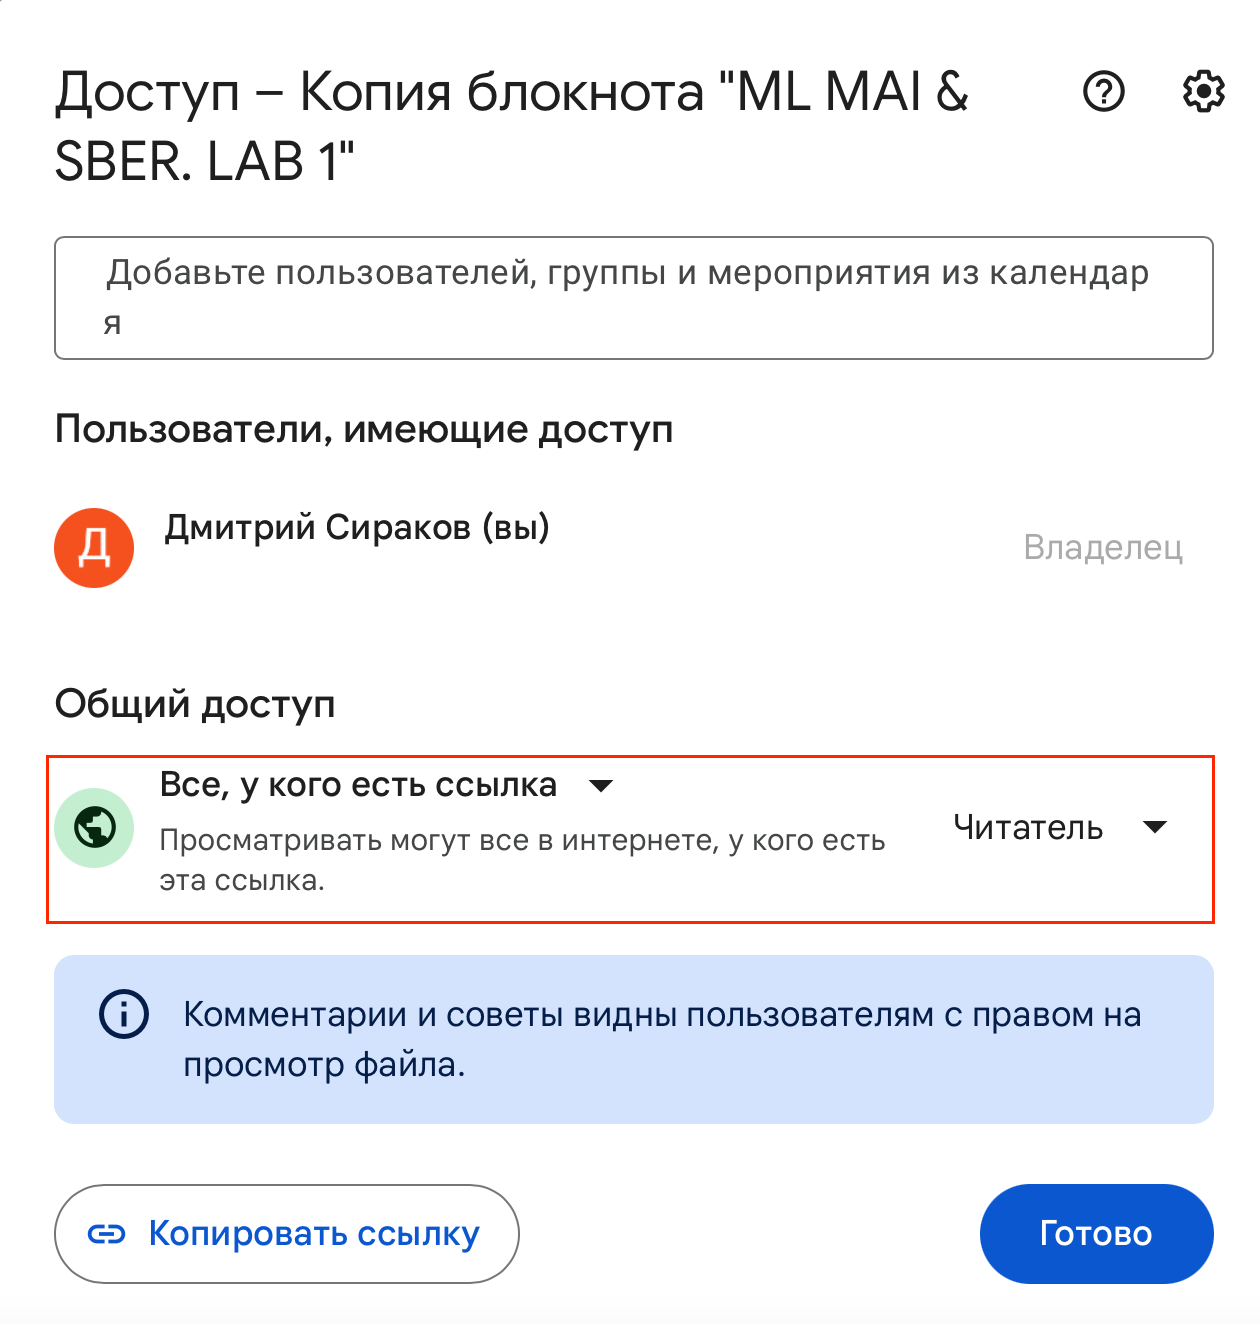

4. Загрузите эту ссылку в lms.mai.ru по курсу "Машинное обучение" в качестве ссылки в раздел "Линейная классификация с Scikit-learn и Seaborn для визуализации (ЛР)[06.04]"


## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты не могут получить за него больше 0 баллов.

Неэффективная реализация кода может негативно отразиться на оценке.

# Часть 1. SVM, LR и калибровка вероятностей (1.25 балла)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.25 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

**AUC-ROC**:
- ROC-кривая (Receiver Operating Characteristic curve) - это график, который показывает производительность классификационной модели при всех пороговых значениях классификации. Она изображает две величины: True Positive Rate (TPR, чувствительность) и False Positive Rate (FPR, 1-специфичность).
- AUC (Area Under the Curve) - это площадь под ROC-кривой. Значение AUC лежит в диапазоне от 0 до 1. Модель с AUC, равным 1, является идеальным классификатором, а модель с AUC, равным 0.5, не имеет классификационной способности.

**AUC-PR**:
- PR-кривая (Precision-Recall curve) - это график, который показывает зависимость точности (precision) от полноты (recall) для различных пороговых значений.
- AUC-PR также является площадью под PR-кривой. Эта метрика особенно полезна в случаях, когда классы сильно несбалансированы. Максимальное значение AUC-PR равно 1, что означает идеальную классификацию, а минимальное значение зависит от соотношения классов в данных.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: потому что это вероятность принадлежности к положительному классу

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


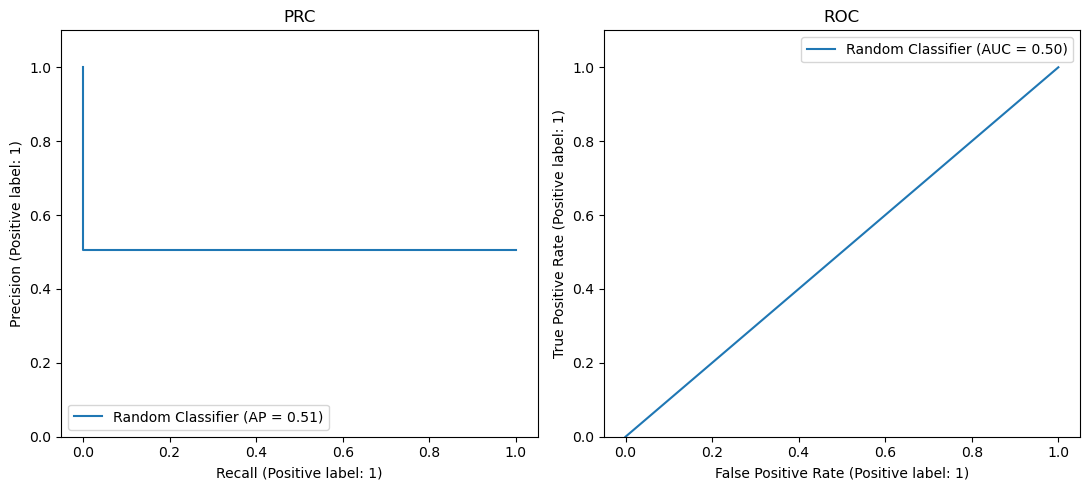

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


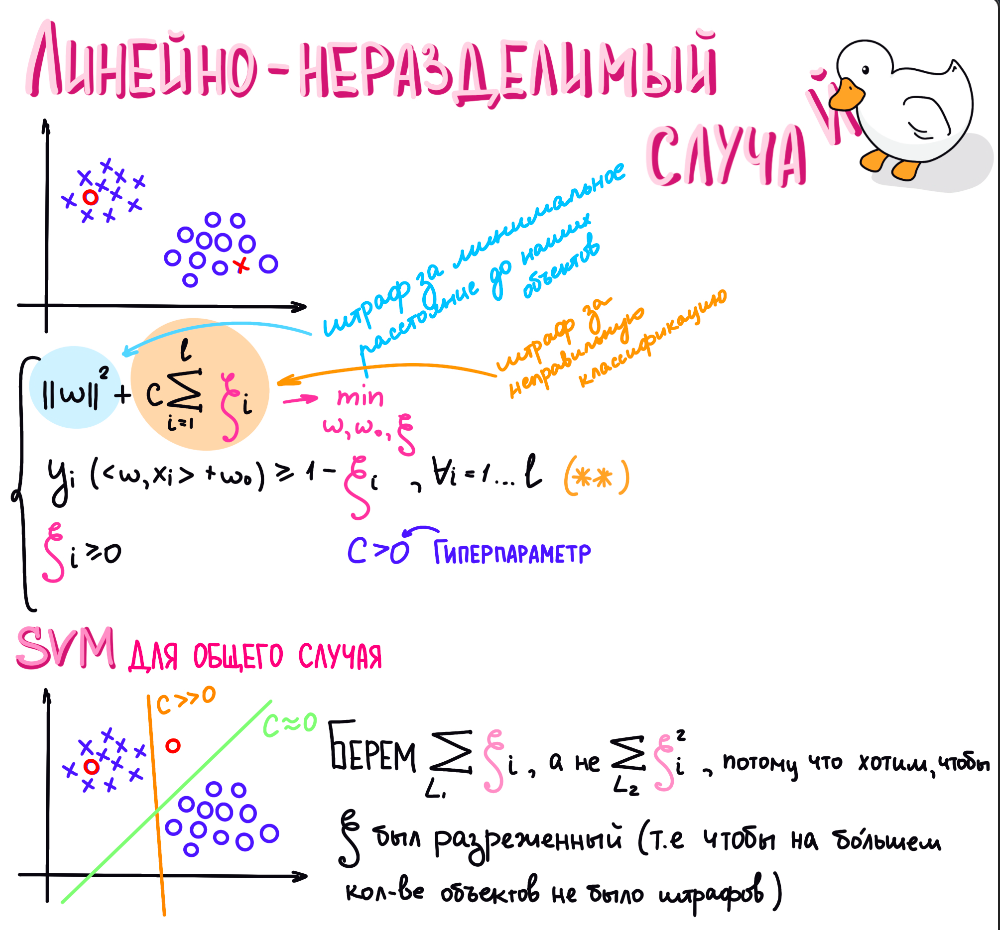

In [8]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV


clf = svm.SVC(kernel='linear')

# Задаем сетку параметров для GridSearchCV
param_grid = {'C': [0.01, 0.1, 0.2, 0.5, 1]}

# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=3)


grid_search.fit(X_train, y_train)


best_c = grid_search.best_params_['C']
print("Лучший параметр C:", best_c)


best_model = grid_search.best_estimator_

# Предсказываем метки классов для тестового набора
y_pred_svm = best_model.predict(X_test)


Лучший параметр C: 0.2


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

svm metrics
AUC-PR: 0.83369
AUC-ROC: 0.77514


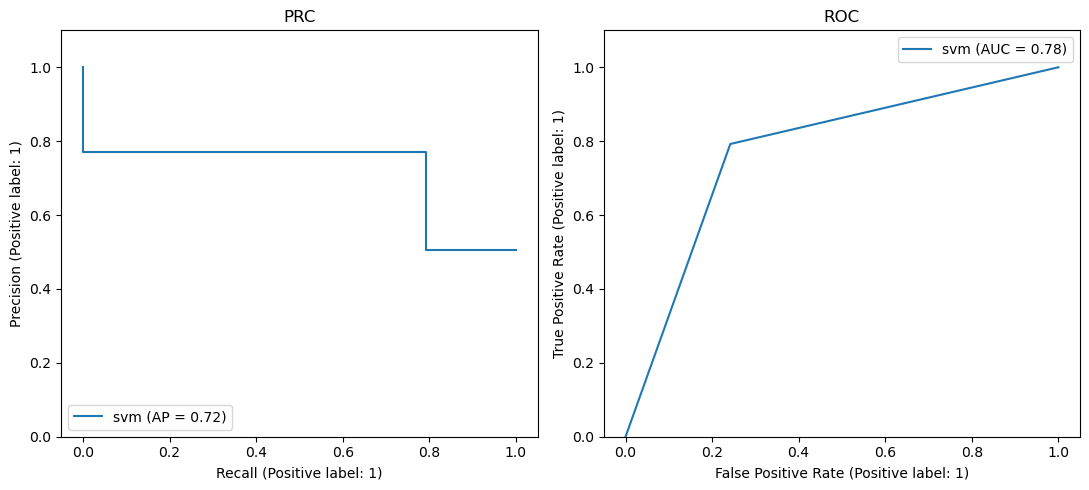

In [9]:
depict_pr_roc(y_test, y_pred_svm, 'svm')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_random)
auc_pr_random = auc(recall, precision)
auc_roc_random = roc_auc_score(y_test, y_random)

precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)
auc_pr_svm = auc(recall, precision)
auc_roc_svm = roc_auc_score(y_test, y_pred_svm)

print(f'PR-AUC better in {auc_pr_svm/auc_pr_random:3f} times than a random, ROC-AUC better in {auc_roc_svm/auc_roc_random:3f} times than a random')

PR-AUC better in 1.107398 times than a random, ROC-AUC better in 1.550276 times than a random


__Logistic Regression__





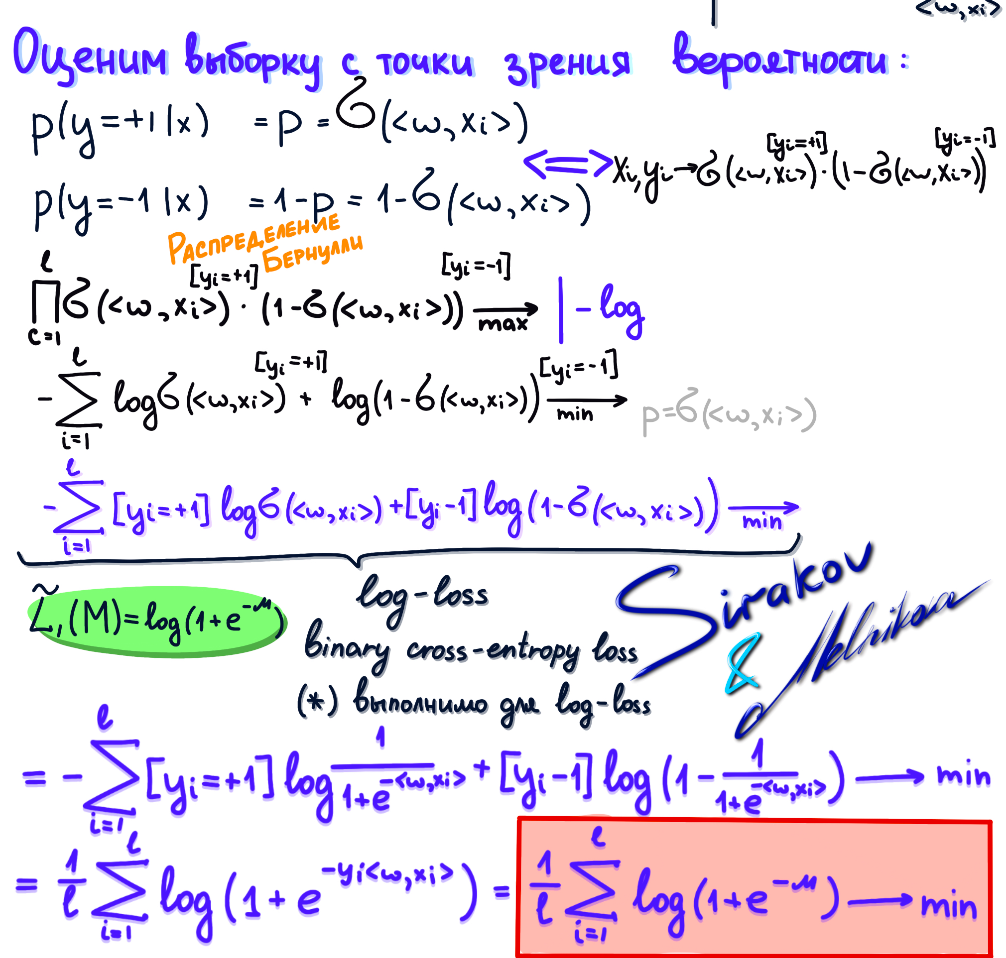

Давай проведем анализ эффективности логистической регрессии с регуляризацией L2 для бинарной классификации.

Вот наши шаги:

1. **Определение гиперпараметра C**: Начнем с подбора гиперпараметра C, который контролирует силу регуляризации в логистической регрессии. Для этого используем метрику AUC-PR, которая показывает баланс между точностью и полнотой. Выбор оптимального значения C поможет нам улучшить производительность модели, особенно в условиях несбалансированных данных.

2. **Визуализация кривых ROC и PR**: После того как мы определим наилучший гиперпараметр C, нарисуем ROC и PR кривые для тестовых данных. Эти кривые помогут нам оценить, насколько хорошо наша модель различает классы и как она справляется с балансом между точностью и полнотой.

3. **Оценка метрик**: Наконец, выведем ключевые метрики для тестовых данных, такие как AUC-ROC и AUC-PR, чтобы оценить производительность логистической регрессии. Сравним эти результаты с показателями случайного классификатора, чтобы понять, насколько наша модель превосходит случайное угадывание.


In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear')

param_grid = {'C': [0.001, 0.01, 0.1]}

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_c = grid_search.best_params_['C']

print("Best Parameter for c is: ", best_c)
best_model = grid_search.best_estimator_
y_pred_log_reg = best_model.predict(X_test)

Best Parameter for c is:  0.01


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier AUC-PR: 0.75283
Random Classifier AUC-ROC: 0.50000
SVM AUC-PR: 0.83369
SVM AUC-ROC: 0.77514
Logistic Regression AUC-PR: 0.83217
Logistic Regression AUC-ROC: 0.77243


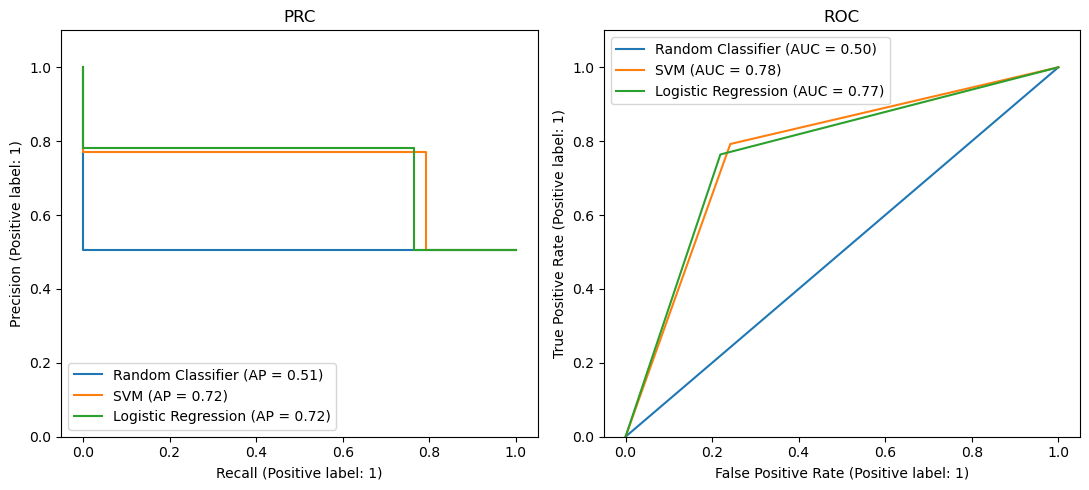

In [18]:
def depict_pr_roc_all(y_true_all, y_pred_all, classifier_names, ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
  for i in range(len(classifier_names)):
    classifier_name = classifier_names[i]
    y_true = y_true_all[i]
    y_pred = y_pred_all[i]
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print(classifier_name + ' AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print(classifier_name + ' AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc_all([y_test, y_test, y_test], [y_random, y_pred_svm, y_pred_log_reg], ['Random Classifier', 'SVM', 'Logistic Regression'])

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** SVM и Logistic Regression эффективны, SVM чуть лучше по AUC.


#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.25 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [19]:
X, y = make_classification(n_samples=400, n_features=2, n_informative=2, n_redundant=0, random_state=42)
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X,y)

SVC(kernel='linear')

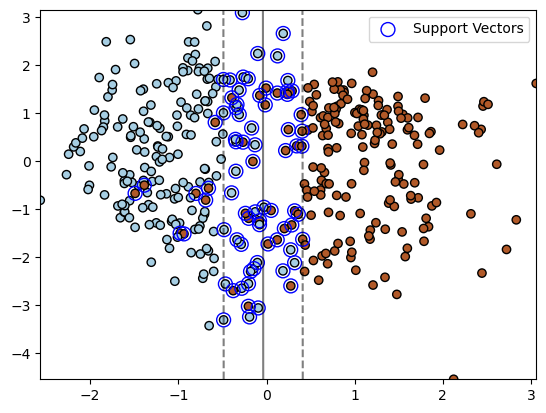

In [23]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # Создаем сетку точек для визуализации разделяющей прямой
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Предсказываем классы 
    Z = model.decision_function(xy).reshape(XX.shape)

    # Визуализируем прямую
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Визуализируем объекты выборки
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    # Визуализируем опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                    s=100, linewidth=1, facecolors='none', edgecolors='blue', label='Support Vectors')

    plt.legend()

    plt.show()


plot_svm_2D(X, y, clf_svm)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** обьекты которые использовались при обучении находятся либо на либо вокруг окрестности разделяющей плоскости

Давайте покажем, как логистическая регрессия отражает вероятности принадлежности к классам в данных. Вместо того чтобы стремиться создать промежуток с отступом, как это делает метод опорных векторов, логистическая регрессия моделирует вероятность того, что объект принадлежит к положительному классу в каждой точке пространства признаков.

Мы собираемся визуализировать, как выглядит пространство вероятностей, которое логистическая регрессия "видит" при прогнозировании классов. На нашем графике каждая точка будет показывать шанс того, что объект относится к положительному классу

In [24]:
clf_lr = LogisticRegression(solver='liblinear', C=0.1)
clf_lr.fit(X,y)

LogisticRegression(C=0.1, solver='liblinear')

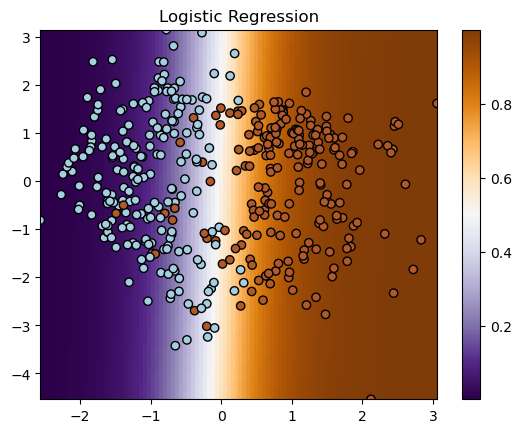

In [26]:
def plot_logreg_2D(X, y, model):

    # Создаем сетку точек
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Получаем вероятности классов для сетки точек
    Z = model.predict_proba(xy)[:, 1].reshape(XX.shape).T

    # Визуализируем пространство вероятностей
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    # Визуализируем выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    plt.colorbar(image)
    plt.title('Logistic Regression')

    plt.show()

# Пример использования
plot_logreg_2D(X, y, clf_lr)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** ?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?
На графике это можно понять по черной градиентной полосе (размытой), чем дальше от нее тем по сути моделька становистя более увереннее


#### __Задание 2. Калибровка вероятностей__ (0.5 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

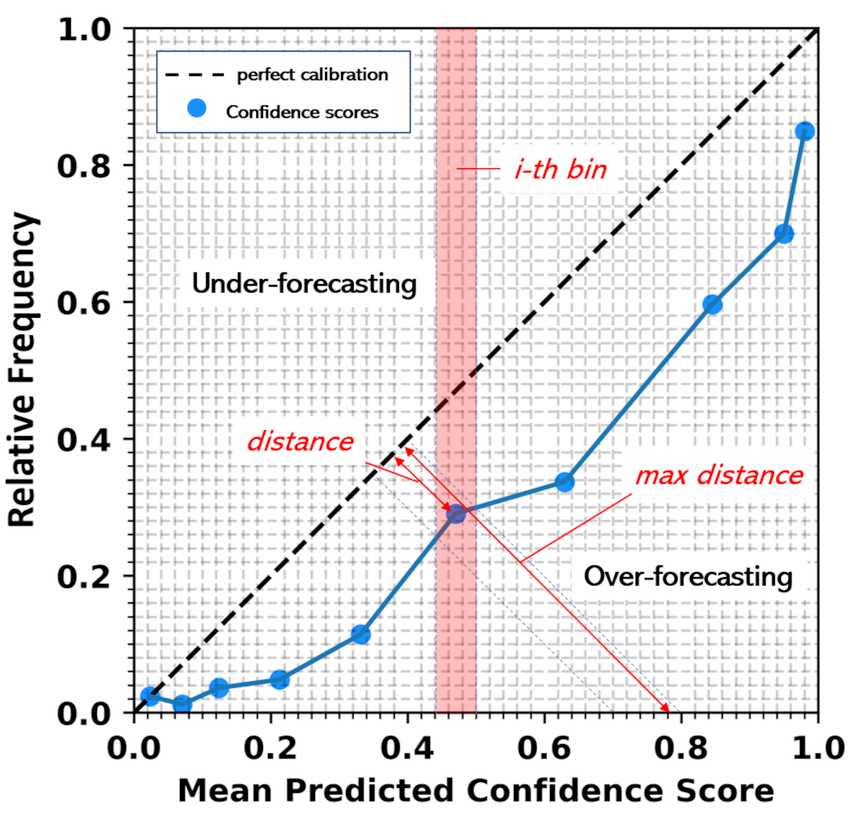

**Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.**

In [47]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        if np.any((preds >= l) & (preds < r)):
            bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)]))
        else:
            bin_real_ratios.append(np.nan)
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, marker='o')
    plt.plot(np.linspace(0.0, 1.0, 100), np.linspace(0.0, 1.0, 100))
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Ratio of Positive Classes')
    plt.title('Calibration Curve')

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [48]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

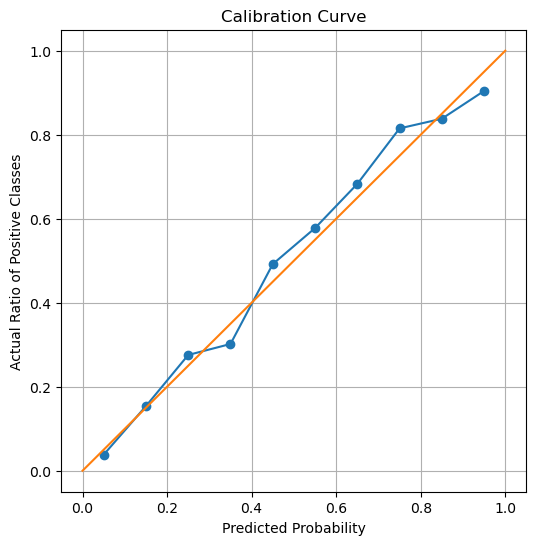

In [49]:
clf_lr = LogisticRegression(solver='liblinear', C=0.2)
clf_lr.fit(X_train, y_train)

plot_calibration_curve(y_test, clf_lr.predict_proba(X_test).T[1].T)

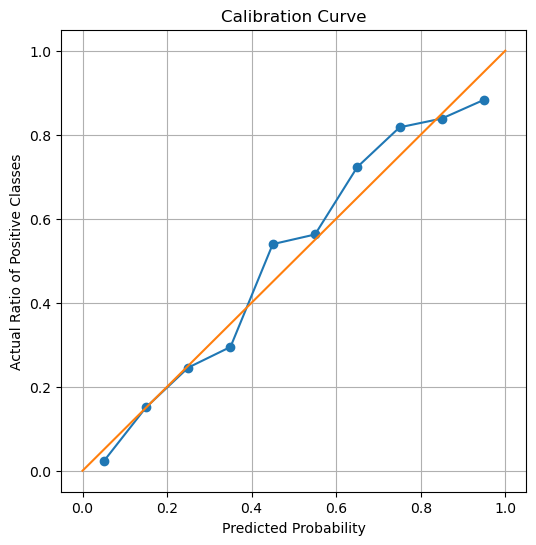

In [50]:
clf_svm = svm.SVC(kernel='linear', C=0.2, probability=True)
clf_svm.fit(X_train, y_train)
plot_calibration_curve(y_test, clf_svm.predict_proba(X_test).T[1].T)


**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** лог рег кажется получше чем SVM

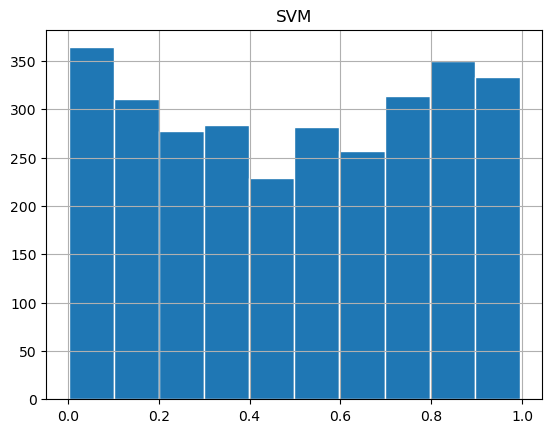

In [57]:
plt.hist(clf_svm.predict_proba(X_test).T[1].T, bins=10, edgecolor='w')
plt.grid(True)
plt.title("SVM")
plt.show()

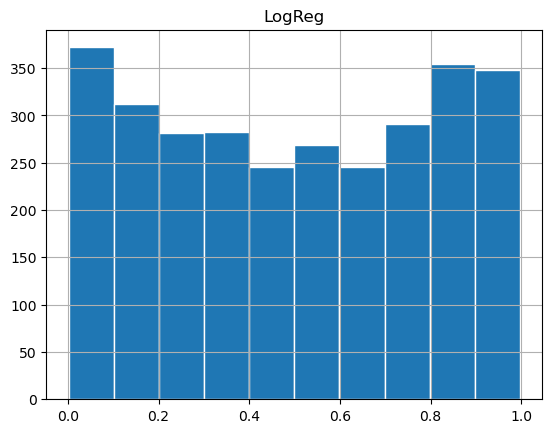

In [55]:
plt.hist(clf_lr.predict_proba(X_test).T[1].T, bins=10, edgecolor='w')
plt.grid(True)
plt.title("LogReg")
plt.show()

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** в logReg напрямую оптимизируется кроссентропилосс, поэтому она лучше (ближе) к идеальным показанеиям


Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [58]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(clf_svm, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=SVC(C=0.2, kernel='linear', probability=True))

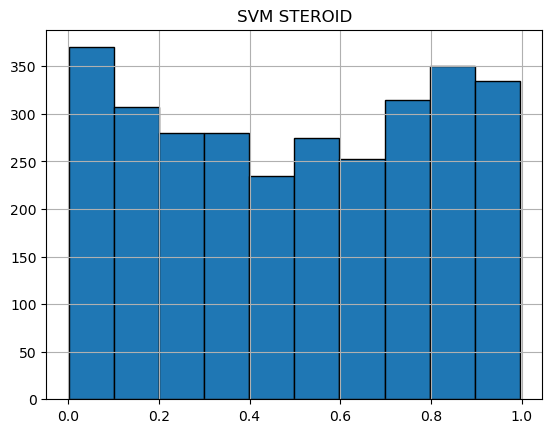

In [59]:
plt.hist(calibrated_clf.predict_proba(X_test).T[1].T, bins=10, edgecolor='black')

plt.title('SVM STEROID')
plt.grid(True)
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** https://avatars.dzeninfra.ru/get-zen_doc/3429702/pub_5fdf3f223713a37b864c7f84_5fdf3fa43713a37b864d4eea/scale_1200

##### __Авторское решение__ (0.25 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

1. **Метод Platt (Platt Scaling):**
   - Идея: Метод Platt предполагает применение сигмоидной функции к выходным данным модели для преобразования их в вероятности. Это делается путем обучения дополнительной логистической регрессии на выходах модели.
   - Алгоритм:
     1. Обучите классификатор и получите выходные значения (например, расстояния от гиперплоскости в SVM).
     2. Примените сигмоидную функцию к выходным значениям:
$$
P(y=1|x) = \frac{1}{1 + \exp(Af(x) + B)}
$$ , где A и B - параметры, обучаемые с использованием максимального правдоподобия на обучающем наборе.

2. **Изотоническая регрессия (Isotonic Regression):**
   - Идея: Изотоническая регрессия стремится калибровать вероятности так, чтобы они были монотонно возрастающими относительно выходных значений модели. Это делается путем построения кусочно-линейной функции, которая аппроксимирует истинные вероятности.
   - Алгоритм:
     1. Отсортируйте выходные значения модели и соответствующие истинные метки.
     2. Найдите кусочно-линейную аппроксимацию, которая минимизирует среднеквадратичную ошибку между аппроксимированными вероятностями и истинными метками, сохраняя при этом монотонность.

**Различия:**
- Platt Scaling предполагает использование сигмоидной функции и подходит для моделей, выходы которых могут быть интерпретированы как логиты (например, SVM). Этот метод может не гарантировать монотонность вероятностей.
- Изотоническая регрессия не делает предположений о форме функции, связывающей выходы модели с вероятностями, и стремится к монотонности. Это делает ее более гибкой, но потенциально менее устойчивой при малом количестве данных.


In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

# Часть 2. Обработка категориальных переменных (1.75 балла)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__


Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [60]:
df = pd.read_csv('bike_buyers.csv')

#Разделим на категориальные признаки и числовые
X_numerical_names = ['Income', 'Children', 'Cars', 'Age']
X_categorical_names = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

В начале поработаем только с категориальными признаками

In [61]:
#Заменим пропуски категориальных переменных
df[X_categorical_names] = df[X_categorical_names].fillna('undefined')

In [62]:
X_numerical = df[X_numerical_names]
X_categorical = df[X_categorical_names]

In [63]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.25 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [69]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import time


time_1 = time.time()
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

LR = LogisticRegression()

LR.fit(X_train_encoded, y_train)
y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

time_2 = time.time()
delta = time_2 - time_1
print("AUC-PR:", auc_pr)
print(f"{delta}: required time")

AUC-PR: 0.5883009320176316
0.009001731872558594: required time


#### __Задание 4. One-Hot Encoding__ (0.25 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [72]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import time

# Начало времени измерения
time_1 = time.time()

# Создание и обучение one-hot encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Создание и обучение модели логистической регрессии
LR = LogisticRegression()
LR.fit(X_train_encoded, y_train)

# Предсказание вероятностей
y_pred_proba = LR.predict_proba(X_test_encoded)[:, 1]

# Вычисление AUC-PR
auc_pr_one_hot = average_precision_score(y_test, y_pred_proba)

# Окончание времени измерения
time_2 = time.time()
encoding_training_time = time_2 - time_1

# Вывод результатов
print("AUC-PR после one-hot-кодирования:", auc_pr_one_hot)
print(f"Encoding and training time: {encoding_training_time:.5f} seconds")

AUC-PR после one-hot-кодирования: 0.666642757355176
Encoding and training time: 0.05926 seconds


C:\Programming\anaconda3\envs\test2\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (0.5 балла)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Напомню идею формулы:
   - `g_j(x, X)` - новое значение признака `f_j(x)` после кодирования счётчиками.
   - `f_j(x)` - значение j-го категориального признака для объекта `x`.
   - `f_j(x_i)` - значение j-го категориального признака для i-го объекта в обучающем наборе данных `X`.
   - `y_i` - значение целевой переменной для i-го объекта.
   - `[...]` - скобки обозначают индикаторную функцию, которая равна 1, если условие внутри них истинно, и 0 в противном случае.
   - В числителе суммируются значения целевой переменной для объектов, у которых признак `f_j` равен значению признака `f_j(x)` для текущего объекта `x`, и эти значения целевой переменной равны +1.
   - В знаменателе подсчитывается общее количество объектов, у которых признак `f_j` равен значению признака `f_j(x)` для текущего объекта `x`.

**Результат:** Каждое уникальное значение категориального признака заменяется средним значением целевой переменной по всем объектам этой категории. Это позволяет сохранить информацию о связи между категориальным признаком и целевой переменной без увеличения размерности признакового пространства, как это происходит при one-hot encoding.\
\
\
\
Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.\

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.mapping = {}

    def fit(self, X, y):
      for col in self.columns:
          target_mean = y.groupby(X[col]).mean()
          self.mapping[col] = target_mean
      return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.columns:
            X_encoded[col + '_encoded'] = X[col].map(self.mapping[col])
        return X_encoded.drop(columns=self.columns)


In [76]:
from sklearn.pipeline import Pipeline

# Создаем пайплайн с кодированием счётчиками и обучением модели логистической регрессии
pipeline = Pipeline([
    ('encoder', TargetEncoderTransformer(columns=X_categorical_names)),
    ('classifier', LogisticRegression())
])

time_1 = time.time()

# Обучаем пайплайн
pipeline.fit(X_train, y_train)

time_2 = time.time()

count_encoding_training_time = time_2 - time_1

# Получаем прогнозы
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Оцениваем качество модели
auc_pr_count_encoder = average_precision_score(y_test, y_pred_proba)

print("AUC-PR после кодирования счётчиками:", auc_pr_count_encoder)
print("Время кодирования и обучения (секунды):", count_encoding_training_time)

AUC-PR после кодирования счётчиками: 0.6575408792625901
Время кодирования и обучения (секунды): 0.02267146110534668


**Mean-target encoding** может привести к переобучению (если у нас есть маленькие категории, то мы просто запомним для них целевую переменную). Чтобы избежать переобучения необходимо вычислять счётчики таким образом, чтобы целевая метка конкретного объекта не влияла напрямую на его собственное значение признака. Для этого можно использовать следующие методы:

1. **Вычисление по предшествующим объектам:** Если данные отсортированы по времени или другому критерию, можно вычислять значение счётчика для каждого объекта, используя только те объекты, которые находятся выше в датасете. Таким образом, целевая метка текущего объекта не участвует в вычислении его признака. (собственно так реализовано в знаменитой библиотеке от Yandex Catboost)

2. **Вычисление по фолдам:** Можно разделить выборку на несколько частей (фолдов) и для каждой части вычислить значение признака, используя данные из всех остальных фолдов. Этот подход аналогичен методу кросс-валидации и позволяет избежать использования целевой метки объекта при вычислении его признака.

3. **Добавление шума:** Внесение небольшого случайного шума в посчитанные значения признаков может также помочь снизить риск переобучения, делая признаки менее "идеальными" и более устойчивыми к изменениям в данных.


#### __Задание 6. Пошумим, блин!__  (0.25 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** ?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

#### __Задание 7. Сглаживание счетчиков__  (0.5 балла)

Давайте рассмотрим ситуацию, когда определенная категория встречается в датасете всего несколько раз. В таком случае, среднее значение целевой переменной для этой категории может быть нестабильным и привести к переобучению. Чтобы уменьшить этот риск, используется сглаживание счётчиков.

Один из способов сглаживания - это использование среднего значения по всей выборке. В этом случае формула для вычисления значения счётчика модифицируется следующим образом:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

Здесь:
- $global\_mean$ — это доля объектов положительного класса во всей выборке.
- $C$ — параметр сглаживания, который контролирует баланс между средним значением по категории и глобальным средним. Большие значения $C$ увеличивают влияние глобального среднего, что полезно для редких категорий.

Смысл сглаживания в том, что мы "разбавляем" среднее значение по категории глобальным средним. Это помогает сделать признак более устойчивым, особенно для категорий с малым количеством объектов.

**Пример:** Представим, что у нас есть категория "цвет автомобиля", и в выборке всего два красных автомобиля, один из которых положительный (например, продан), а другой отрицательный (не продан). Без сглаживания счётчик для красных автомобилей будет равен 0.5. Однако, если использовать сглаживание с $C = 10$ и $global\_mean = 0.3$ (30% автомобилей в выборке проданы), то счётчик для красных автомобилей будет равен:

$$
g_j(\text{"красный"}, X) = \frac{1 + 10 \times 0.3}{2 + 10} = \frac{4}{12} = 0.33
$$

Таким образом, значение счётчика становится ближе к глобальному среднему, что делает его менее чувствительным к случайностям в данных.

Повторите эксперименты с добавлением сглаживания и подберите параметр $C$ так, чтобы качество модели было лучше, чем при использовании One-Hot-Encoding.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

# Часть 3. Отбор признаков (1 балл)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

Отбор признаков - важный этап в построении модели. Некоторые признаки могут не вносить значимый вклад в модель или даже ухудшать её качество, при этом их вычисление требует времени. Давайте попробуем разные способы отбора признаков и оценим их влияние на качество модели и время, затраченное на их обработку.

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

#### __Задание 8. Встроенные методы (0.25 балла)__

Давайте выберем 40 самых важных признаков с помощью линейной модели. В линейной модели веса показывают, насколько сильно каждый признак влияет на прогноз. Мы можем использовать модуль этих весов, чтобы оценить важность признаков. Этот подход называется встроенным методом отбора признаков.

Выберем 40 признаков с самыми большими весами, обучим модель снова и проверим её качество. Также замерим, сколько времени занимает этот процесс отбора признаков.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Изменилось ли качество? Как?

Мы предполагали, что все признаки вносят равный вклад, не учитывая их масштаб. Но масштаб важен: если увеличить признак в 100 раз, его вес в модели уменьшится на 100. Поэтому, прежде чем выбирать признаки, нужно их отмасштабировать.

Сначала масштабируем признаки, а затем удалим ненужные. Пересчитаем качество модели на всех признаках. Если вы уже масштабировали признаки в начале, попробуйте теперь отобрать признаки на данных без масштабирования.

Какой результат получился?

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

#### __Задание 9. Методы фильтрации (0.25 балла)__


Давайте выберем признаки более осмысленно, используя методы фильтрации. Эти методы выбирают признаки на основе некоторой статистической функции. Мы будем использовать t-статистику для каждого признака:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ - среднее, стандартное отклонение и количество объектов для каждого класса.

*Интуиция формулы:*

Идея t-статистики заключается в том, чтобы оценить, насколько сильно средние значения признака отличаются между двумя классами, с учетом разброса (дисперсии) значений признака внутри каждого класса.

- Числитель $|\mu_+ - \mu_-|$ показывает абсолютную разницу между средними значениями признака в положительном и отрицательном классах. Чем больше эта разница, тем более вероятно, что признак важен для разделения классов.

- Знаменатель $\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}$ учитывает стандартные отклонения признака в каждом классе и количество объектов в классах. Это помогает учесть, насколько сильно значения признака разбросаны внутри классов. Если разброс большой, то разница средних может быть менее значимой.

В итоге, если значение t-статистики велико, это говорит о том, что признак имеет высокую дискриминационную способность между классами, то есть хорошо помогает их различать. Поэтому мы отбираем признаки с наибольшими значениями t-статистики, полагая, что они наиболее важны для модели.

Выберем 40 признаков с самым высоким значением t-статистики, обучим модель заново и оценим её качество. Также замерим время, затраченное на отбор признаков.


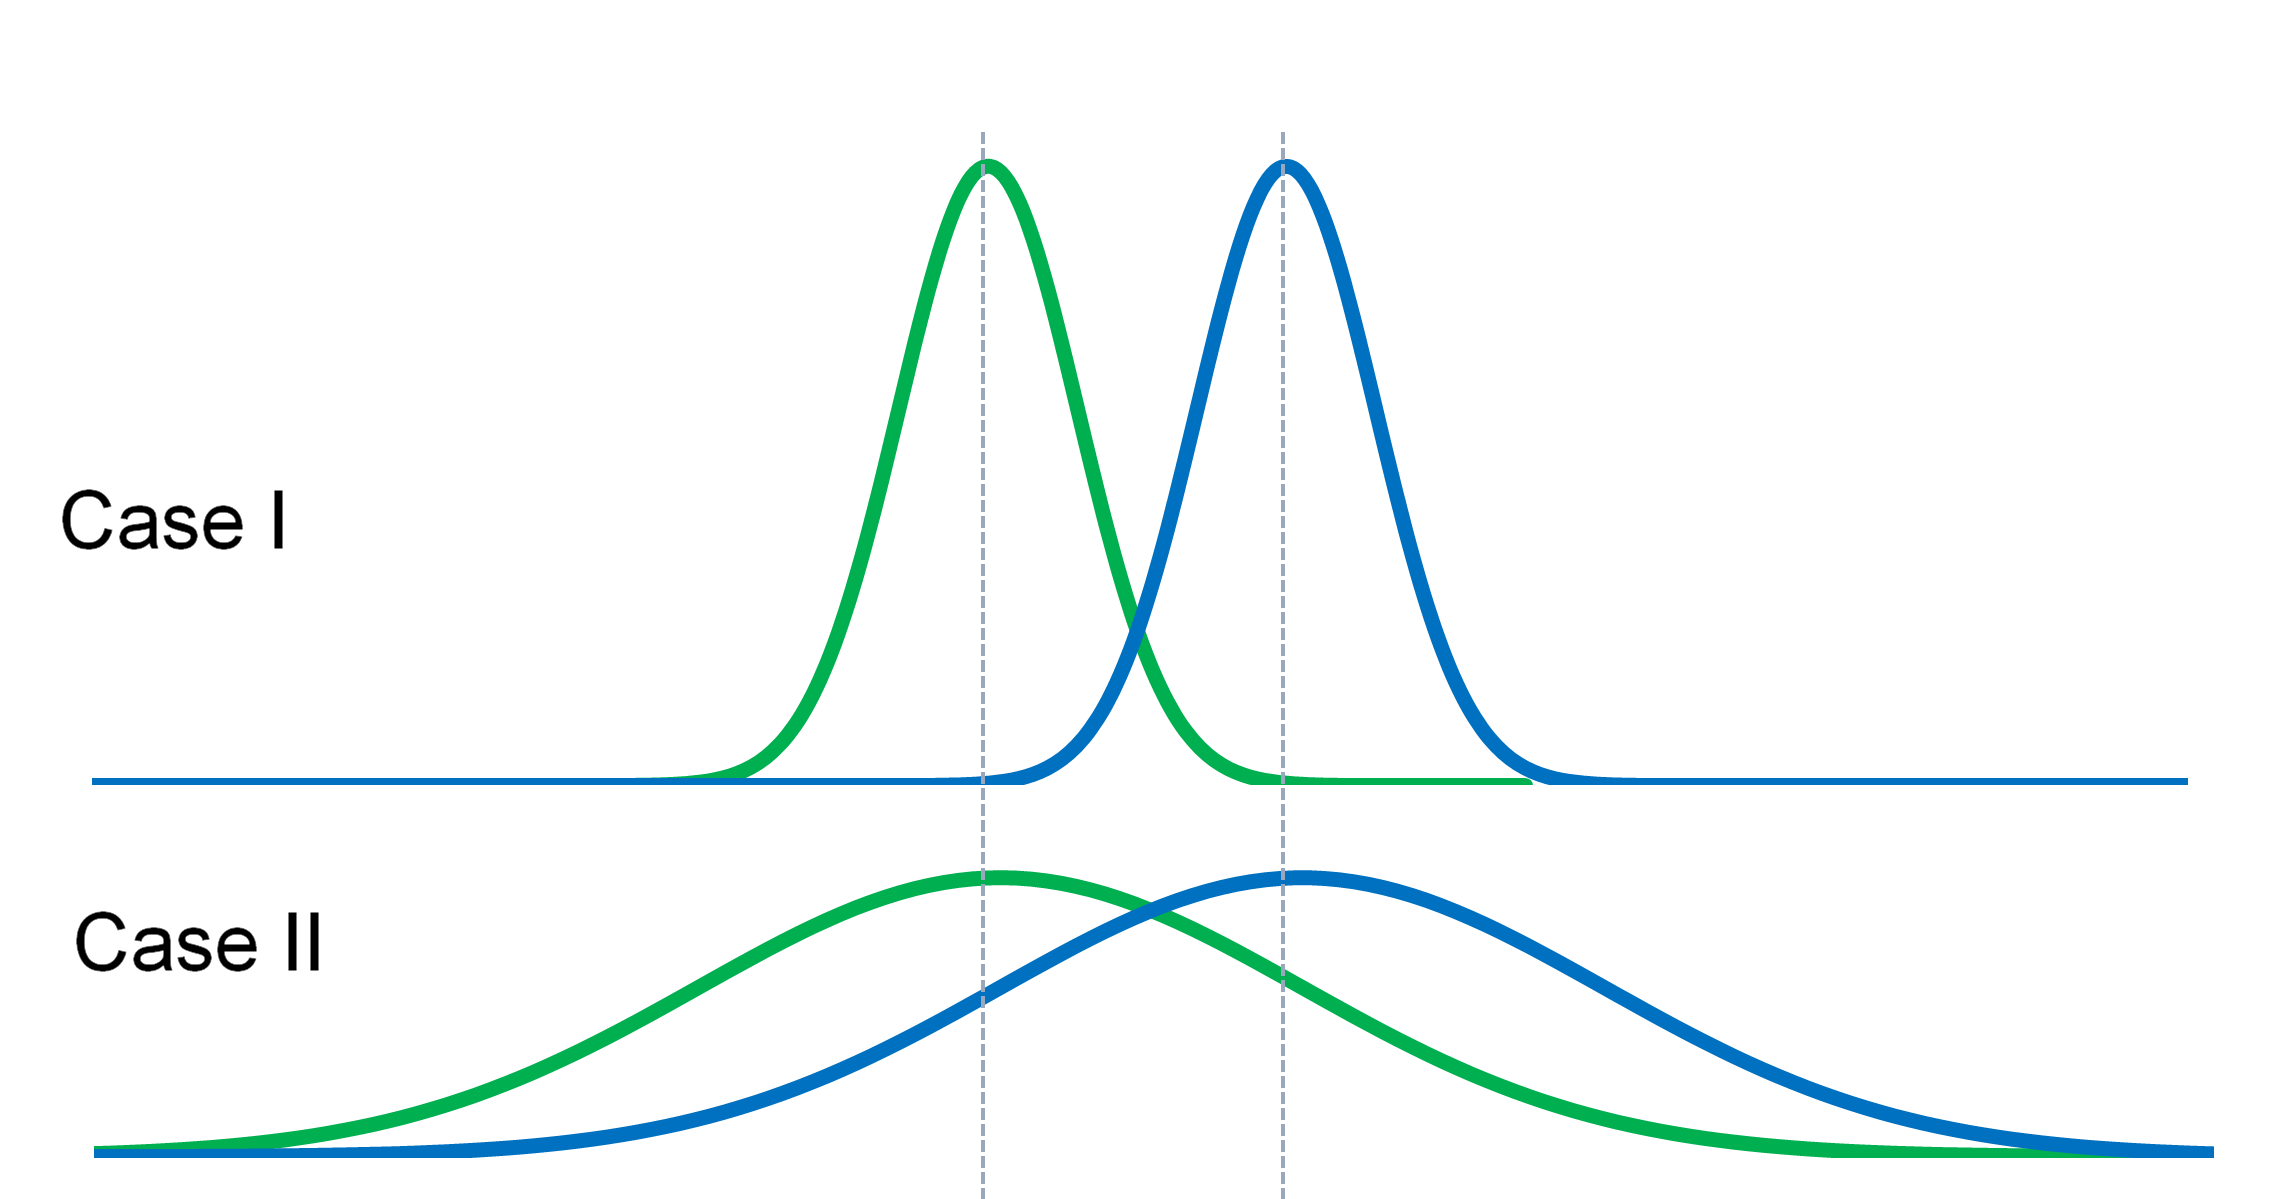

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

#### __Задание 10. Методы-обёртки__ (0.5 балла)

Третий из рассматриваемых нами методов работает следующим образом: мы используем жадный метод удаления признаков: на каждом шаге убираем тот признак, который меньше всего влияет на качество модели. Продолжаем так, пока не останется 40 признаков или пока качество не начнет сильно падать.

Важно: оцениваем качество не на тестовой выборке, чтобы избежать переобучения. Для этого делим обучающую выборку на две части: на одной обучаем модель без одного признака, на другой - проверяем качество. Тестовую выборку используем только для финальной проверки.

**Пример:** Предположим, у нас есть модель с признаками A, B, C, D. Сначала убираем признак A, обучаем модель на B, C, D и проверяем качество. Затем возвращаем A, убираем B и так далее. Если оказалось, что без признака C качество выше всего, убираем C навсегда. Продолжаем, пока не останется 40 признаков.

После отбора 40 признаков оцениваем качество на тестовой выборке и замеряем время, затраченное на отбор.


In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** ?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

# Часть 4. Оценка экономического эффекта (1 балл)



В этой части мы сосредоточимся на задачах, которые часто встречаются на практике (помимо рекурсивного обхода`json` и перекладывания`.yml`файлов, разумеется):

- Создадим несколько специализированных метрик качества.
- Настроим модель так, чтобы максимизировать прибыль.
- Оценим потенциальный доход от использования модели.

Для простоты введем некоторые упрощения. Напомним, что выручка - это сумма денег, полученная от клиентов, а прибыль - это выручка за вычетом расходов, таких как зарплата и другие затраты.


#### __Задание 11. Прогноз по доходам и расходам__ (0.5 балла)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=555`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

#### __Задание 12. Ключевая метрика__ (0.5 балла)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ #?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#?( ?? ?? ?? )????*:??   ?^•?•^?   ?•?•?